In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import warnings

from sklearn.feature_extraction.image import PatchExtractor
from sklearn.linear_model import Lasso

from sparse_coding import model, inference
from imp import reload

In [2]:
ims = np.transpose(loadmat('IMAGES.mat')['IMAGES'], (2, 0, 1))

In [3]:
patch_size = (8, 8)
n_feat = np.prod(patch_size)
X = PatchExtractor(patch_size=patch_size, max_patches=500, random_state=0).transform(ims)
X = X.reshape(X.shape[0], -1)

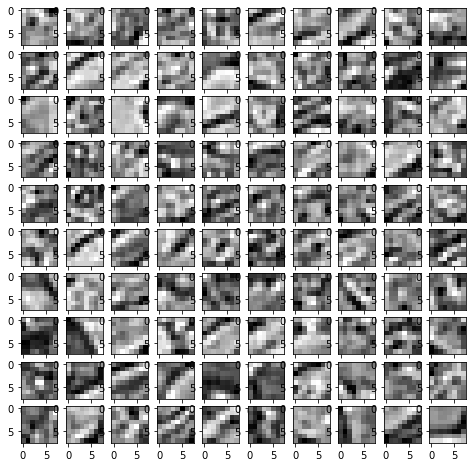

In [4]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8))

for ii, ax in enumerate(axes.ravel()):
    ax.imshow(X[ii].reshape(*patch_size), cmap='gray')

In [5]:
m = model.SparseCoding(64, lambd=0.1, device='cpu', dtype=torch.float32, learn_method='lbfgsb', infer_method='cd')

In [6]:
m.fit(X)

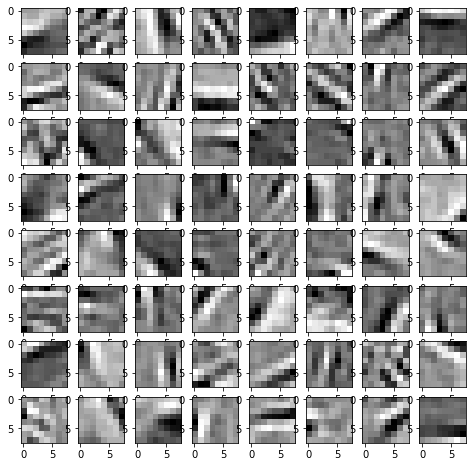

In [7]:
fig, axes = plt.subplots(8, 8, figsize=(8, 8))

for ii, ax in enumerate(axes.ravel()):
    ax.imshow(m.D[ii].reshape(patch_size), cmap='gray')

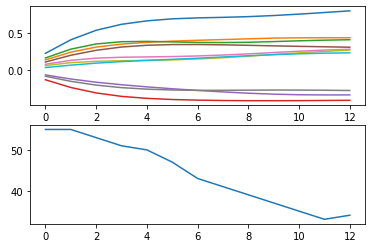

In [8]:
sl = [0, 1]
m.infer_method = 'fista'
s_fista = m.transform(X[sl], return_history=True)
idxs = np.argsort(abs(s_fista[-1, 0]))[::-1]
n_active = np.sum(abs(s_fista[:, 0]) > 0, axis=1)
fig, axes = plt.subplots(2)
for ii in range(10):
    axes[0].plot(s_fista[:, 0, idxs[ii]])
axes[1].plot(n_active)

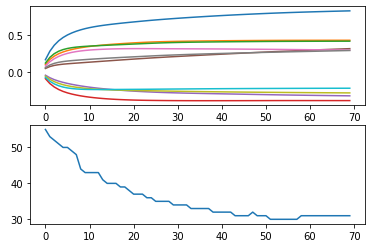

In [9]:
m.infer_method = 'ista'
s_ista = m.transform(X[sl], return_history=True)
idxs = np.argsort(abs(s_ista[-1, 0]))[::-1]
n_active = np.sum(abs(s_ista[:, 0]) > 0, axis=1)
fig, axes = plt.subplots(2)
for ii in range(10):
    axes[0].plot(s_ista[:, 0, idxs[ii]])
axes[1].plot(n_active)

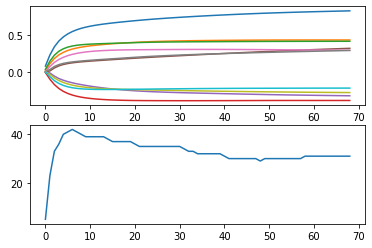

In [10]:
m.infer_method = 'lca'
s_lca = m.transform(X[sl], return_history=True)
idxs = np.argsort(abs(s_lca[-1, 0]))[::-1]
n_active = np.sum(abs(s_lca[:, 0]) > 0, axis=1)
fig, axes = plt.subplots(2)
for ii in range(10):
    axes[0].plot(s_lca[:, 0, idxs[ii]])
axes[1].plot(n_active)

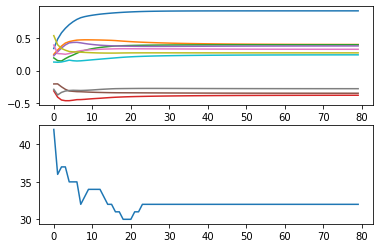

In [11]:
m.infer_method = 'cd'
m.kwargs = {'tol': 1e-4}
s_cd = m.transform(X[sl], return_history=True)
m.kwargs = {}
idxs = np.argsort(abs(s_cd[-1, 0]))[::-1]
n_active = np.sum(abs(s_cd[:, 0]) > 0, axis=1)
fig, axes = plt.subplots(2)
for ii in range(10):
    axes[0].plot(s_cd[:, 0, idxs[ii]])
axes[1].plot(n_active)

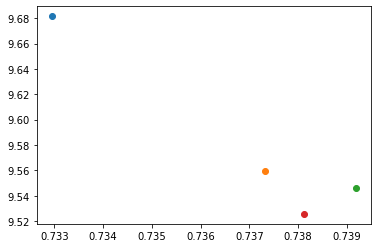

In [17]:
plt.scatter(np.linalg.norm((s_fista[-1] @ m.D) - X[sl])**2, np.sum(abs(s_fista[-1])))
plt.scatter(np.linalg.norm((s_ista[-1] @ m.D) - X[sl])**2, np.sum(abs(s_ista[-1])))
plt.scatter(np.linalg.norm((s_lca[-1] @ m.D) - X[sl])**2, np.sum(abs(s_lca[-1])))
plt.scatter(np.linalg.norm((s_cd[-1] @ m.D) - X[sl])**2, np.sum(abs(s_cd[-1])))

In [13]:
np.linalg.norm((s_ista[-1] @ m.D) - X[sl])**2, np.sum(abs(s_ista[-1]))

(0.7373106541646641, 9.55963)

In [14]:
np.linalg.norm((s_lca[-1] @ m.D) - X[sl])**2, np.sum(abs(s_lca[-1]))

(0.7391896251861376, 9.545706)

In [15]:
np.linalg.norm((s_cd[-1] @ m.D) - X[sl])**2, np.sum(abs(s_cd[-1]))

(0.7381131693088876, 9.525637)

In [46]:
m.infer_method = 'fista'
%timeit si = m.transform(X)

121 ms ± 1.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [47]:
m.infer_method = 'cd'
m.kwargs = {'tol': 1e-4}
%timeit si = m.transform(X)
m.kwargs = {}

980 ms ± 40.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
